In [1]:
!pip install -q scikit-learn==0.24.2
!pip install -q xgboost==1.4.1

# Imports

I'm using **XGBRegressor** for making predictions, **GridSearchCV** from Scikit-learn to tune its hyperparameters and **SelectFromModel** to make feature selection. Used metric is MAPE (mean absolute percentage error), because, to my mind, it is easy to interpret in case of predicting prices. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import make_scorer
from sklearn.base import clone
from sklearn.feature_selection import SelectFromModel

# Data loading

Data loading and checking using pandas

In [3]:
train = pd.read_csv('./data/train.csv', index_col='Id')
test = pd.read_csv('./data/test.csv', index_col='Id')

In [4]:
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [5]:
test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml


# Target value distribution

Let's look and price distribution in train dataset using Seaborn histogram and density esimation.

skew = 1.8828757597682129


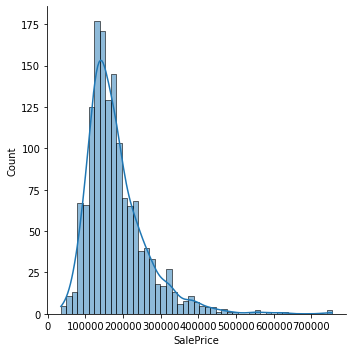

In [6]:
sns.displot(train['SalePrice'], kde=True)
print('skew =', train['SalePrice'].skew())

So, target value is higly skewed. Let's look and its logarithm.

skew of log = 0.12133506220520406


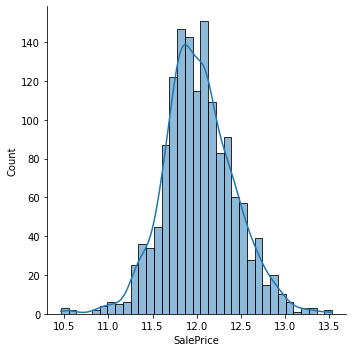

In [7]:
sns.displot(np.log(train['SalePrice']), kde=True)
print('skew of log =', np.log(train['SalePrice']).skew())

Log of target value is more centered and its denstity estimate is quite bell-shaped. However, I won't consider testing normality, because it doesn't matter this much for the task, but it's a good idea to predict logarithm of target value, because it has smaller range of values.

In [8]:
def count_missing(df):
    mis_val = df.isnull().sum()
    mis_percent = 100*mis_val/(len(df))
    result_table = pd.DataFrame(
        {
            "Missing values": mis_val,
            "% of all values": mis_percent
        }).sort_values("% of all values", ascending=False).round(1)
    return result_table

# Missing values

Let's look at missing values in train and test dataset

In [9]:
mis_val_table_train = count_missing(train)
mis_val_table_train[mis_val_table_train["% of all values"] > 0]

,Missing values,% of all values
PoolQC,1453,99.5
MiscFeature,1406,96.3
Alley,1369,93.8
Fence,1179,80.8
FireplaceQu,690,47.3
LotFrontage,259,17.7
GarageYrBlt,81,5.5
GarageCond,81,5.5
GarageType,81,5.5
GarageFinish,81,5.5


In [10]:
mis_val_table_test = count_missing(test)
mis_val_table_test[mis_val_table_test["% of all values"] > 0]

,Missing values,% of all values
PoolQC,1456,99.8
MiscFeature,1408,96.5
Alley,1352,92.7
Fence,1169,80.1
FireplaceQu,730,50.0
LotFrontage,227,15.6
GarageYrBlt,78,5.3
GarageFinish,78,5.3
GarageQual,78,5.3
GarageCond,78,5.3


There not so many features with missing values, but they are informative: for example, NaN in PoolQC means that there is no pool.

# Correlations

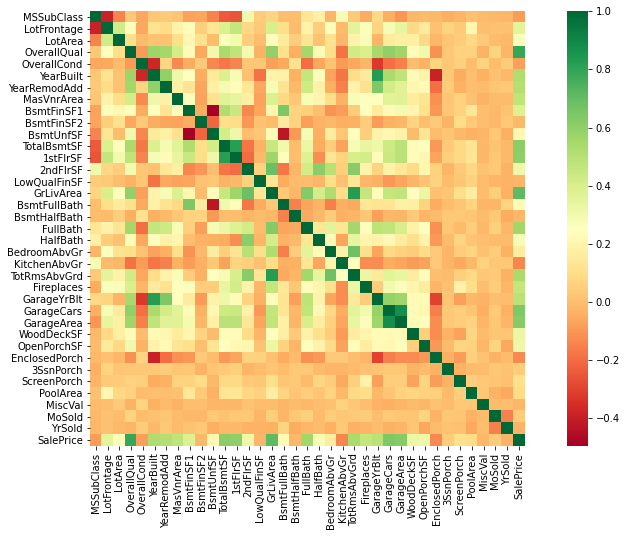

In [11]:
train_corr = train.corr()
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(train_corr, square=True, cmap='RdYlGn')

Top correlations with SalePrice

In [12]:
train_corr['SalePrice'][abs(train_corr['SalePrice']).sort_values(ascending=False).index]

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass      -0.084284
OverallCond     -0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
Name: SalePrice, dtype: float64

High correlating features are quite obvious:

`OverallQual` - Rates the overall material and finish of the house

`GrLivArea` - Above grade (ground) living area square feet

`GarageCars` - Size of garage in car capacity

`GarageArea` - Size of garage in square feet

`TotalBsmtSF` - Total square feet of basement area

`1stFlrSF` - First Floor square feet

`FullBath` - Basement full bathrooms

`TotRmsAbvGrd` - Total rooms above grade (does not include bathrooms)

`YearBuilt` - Original construction date


# Feature engineering

First, let's put log of target value to separate variable and concatenate train and test dataset to process all features simultaneously.

In [13]:
train_labels = np.log(train['SalePrice'])
train = train.drop(columns=['SalePrice'])
train_test = pd.concat([train, test])

It seems a good idea to add total area of basement and 1-2 floors.

In [14]:
train_test['TotalSF'] = train_test['TotalBsmtSF'] + train_test['1stFlrSF'] + train_test['2ndFlrSF']

Let's look and skew of numeric values, since target values is also skewed, and change high skewed features to their logarithms.

In [15]:
num_feat = train_test.dtypes
num_feat = num_feat[num_feat != 'object'].index
feature_skew = train_test[num_feat].skew().sort_values(ascending=False)
feature_skew = feature_skew[abs(feature_skew) > 0.5]
feature_skew

MiscVal          21.958480
PoolArea         16.907017
LotArea          12.829025
LowQualFinSF     12.094977
3SsnPorch        11.381914
KitchenAbvGr      4.304467
BsmtFinSF2        4.147456
EnclosedPorch     4.005950
ScreenPorch       3.948723
BsmtHalfBath      3.932018
MasVnrArea        2.602589
OpenPorchSF       2.536417
WoodDeckSF        1.843380
TotalSF           1.516129
LotFrontage       1.503278
1stFlrSF          1.470360
BsmtFinSF1        1.425722
MSSubClass        1.376165
GrLivArea         1.270010
TotalBsmtSF       1.162882
BsmtUnfSF         0.919824
2ndFlrSF          0.862118
TotRmsAbvGrd      0.758757
Fireplaces        0.733872
HalfBath          0.694924
BsmtFullBath      0.624062
OverallCond       0.570605
YearBuilt        -0.600114
dtype: float64

In [16]:
for feature in feature_skew.index:
    train_test[feature] = np.log1p(train_test[feature])

Categorical variables will be one-hot encoded.

In [17]:
train_test = pd.get_dummies(train_test)
train = train_test[:len(train)]
test = train_test[len(train):]

# Model training and evaluation

Let's fit XGBoost XGBRegressor using GridSearchCV for hyperparameter tuning.

In [18]:
x_train, x_val, y_train, y_val = train_test_split(np.ascontiguousarray(train), train_labels, test_size=0.1)

params = {'n_estimators': [512, 1024, 2048], 'max_depth': [2, 3, 4], 'learning_rate': [0.025, 0.05, 0.1, 0.2]}
clf = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mape'), params, scoring=make_scorer(mape, greater_is_better=False))
clf.fit(x_train, y_train)
print(clf.best_params_, clf.best_score_)

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1024} -0.0069413293794612935


In [19]:
train_pred = clf.predict(x_train)
print('train MAPE =', mape(y_train, train_pred))
val_pred = clf.predict(x_val)
print('validation MAPE =', mape(y_val, val_pred))

train MAPE = 0.0030932507347814905
validation MAPE = 0.005872486215391557


Custom MAPE function, because sklearn's MAPE doesn't represent percentage

In [20]:
def custom_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
print('validation MAPE =', custom_mape(y_val, val_pred))

validation MAPE = 0.5872486215391557


So, validation MAPE is quite low: it means low relative absolute error in predictions - 0.58%

Scatter plots of actual and predicted values

[Text(0, 0.5, 'train predicted'), Text(0.5, 0, 'train true')]

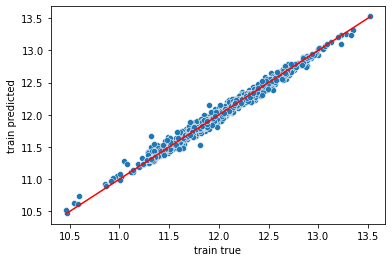

In [22]:
ax = sns.scatterplot(x=y_train, y=train_pred)
sns.lineplot(x=y_train, y=y_train, color='red')
ax.set(xlabel='train true', ylabel='train predicted')

[Text(0, 0.5, 'val predicted'), Text(0.5, 0, 'val true')]

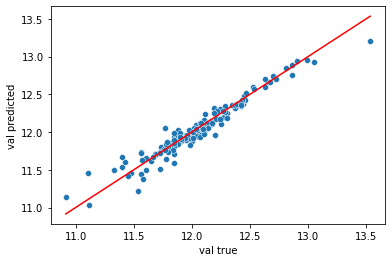

In [23]:
ax = sns.scatterplot(x=y_val, y=val_pred)
sns.lineplot(x=y_val, y=y_val, color='red')
ax.set(xlabel='val true', ylabel='val predicted')

Statistical characteristics of validation prediction error

In [24]:
(y_val-val_pred).describe()

count    146.000000
mean       0.008748
std        0.098238
min       -0.350510
25%       -0.039639
50%        0.012661
75%        0.055886
max        0.323981
Name: SalePrice, dtype: float64

# Feature selection

Feature selection is done with sklearn SelectFromModel. New XGBRegressor is fitted to selected features.

In [25]:
selection = SelectFromModel(clf.best_estimator_, threshold=1e-2, prefit=True)
select_x_train = selection.transform(x_train)

selection_params = {'n_estimators': [256, 512, 768, 1024], 'max_depth': [2, 3, 4], 'learning_rate': [0.025, 0.05, 0.1, 0.2]}
selection_clf = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mape'), selection_params, scoring=make_scorer(mape, greater_is_better=False))
selection_clf.fit(select_x_train, y_train)

print(selection_clf.best_params_)

select_x_val = selection.transform(x_val)
select_val_pred = selection_clf.predict(select_x_val)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 256}


/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [26]:
print('selection validation MAPE =', custom_mape(y_val, select_val_pred))

selection validation MAPE = 0.6933845499999778


After dropping some features with selection, MAPE rose to 0.7%, but it is still a good result.

# Saving predictions

Saving initial model test dataset predictions and predictions after feature selection.

In [27]:
pred = pd.read_csv('./data/sample_prediction.csv', index_col=['Id'])
pred['SalePrice'] = np.exp(clf.predict(test))
pred.to_csv('my_pred_xgb_cv_initial.csv')

pred['SalePrice'] = np.exp(selection_clf.predict(selection.transform(test)))
pred.to_csv('my_pred_xgb_cv_selection.csv')

/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
